In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras.callbacks import TensorBoard
import pickle
from PIL import Image
import time
import os
from PIL import Image
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split

start = time.time()

# Variables

In [ ]:

dim = (176,208)               # input image dimensions                                              (176,208)
test_split_percent = .1       # % of total data for testing                                         .1
validation_split_percent = .2 # % of total data for validation                                      .2
zoom = [.99,1.01]             # zoom range                                                          [.99,1.01]
bright_range = [.8,1.2]       # brightness range                                                    [.8,1.2]
layers_unlocked = True        # unlock the imported pre-training layers?                            False
lr = 0.0001                   # learning rate for optimizer                                         0.0001
batch = 20                    # batch size for model fitting                                        20
eps = 45                      # number of epochs to run                                             50
momentum = .9                 # momentum of SGD                                                     .9

save_model_name = "val%2d_epochs%d"%(validation_split_percent*100,eps)
print(save_model_name)


val20_epochs45


# Import Data From Local Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# This section uses the ImageDataGenerator and flow_from_directory functions to sort the images by label
#actual dimensions 176x208x1

# introduced zoom, blew up the image of the brain itself, and brightness range to adjust for different brightness
train_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,fill_mode='constant',cval=0,
                                                           brightness_range=bright_range,zoom_range=zoom,
                                                           data_format='channels_last',zca_whitening=False)

train_data_gen = train_dr.flow_from_directory(directory=r"/content/drive/MyDrive/train",target_size=dim,
                                              batch_size=5000)

# Change to zoom = [1,1] to use normal test data
test_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,fill_mode='constant',cval=0,zoom_range=[1,1],
                                                          data_format='channels_last')
test_data_gen = test_dr.flow_from_directory(directory=r"/content/drive/MyDrive/test",target_size=dim,batch_size=5000,
                                           shuffle = False) # test data should not be shuffled to keep labels

Found 767 images belonging to 3 classes.
Found 330 images belonging to 3 classes.


# Sanity Checks

In [ ]:
# This section assigns the images to numpy arrays for the data and labels
# EX: train_data = numpy array of image data, train_labels = numpy array of labels

# Use __next__() instead of .next() to retrieve the next batch of data
train_data,train_labels =  next(train_data_gen)
test_data,test_labels = next(test_data_gen)

#val_data,val_labels = val_data_gen.next()

In [ ]:
import gc
gc.collect()

0

In [ ]:
# cocatenate arrays, combining all data
total_data = np.concatenate((train_data,test_data))
total_labels = np.concatenate((train_labels,test_labels))
print(total_data.shape)
print(total_labels.shape)

(1097, 176, 208, 3)
(1097, 3)


In [ ]:
# train test split

initial_split = test_split_percent+validation_split_percent
test_val_split = test_split_percent/initial_split

# split into training and (test + validation)
train_data, test_val_data, train_labels, test_val_labels = train_test_split(total_data,total_labels,
                                                                            test_size=initial_split)

# split (test + validation) into test and validation sets
test_data, val_data, test_labels, val_labels = train_test_split(test_val_data,test_val_labels,
                                                                test_size=test_val_split)

print('train: ',train_data.shape)
print('validation',val_data.shape)
print('test',test_data.shape)

train:  (767, 176, 208, 3)
validation (110, 176, 208, 3)
test (220, 176, 208, 3)


In [ ]:
# Check array dimensions
print(train_data.shape)
print(train_labels.shape)
print(val_data.shape)
print(val_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(767, 176, 208, 3)
(767, 3)
(110, 176, 208, 3)
(110, 3)
(220, 176, 208, 3)
(220, 3)


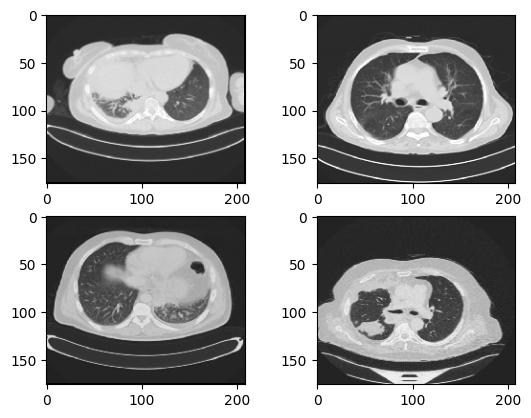

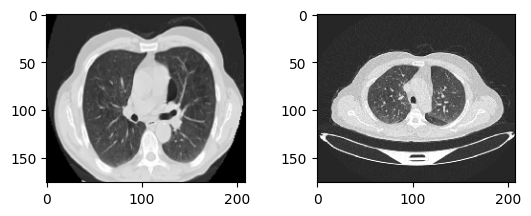

In [ ]:
# check some images
plt.subplot(221)
plt.imshow(train_data[1,:,:,:])
plt.subplot(222)
plt.imshow(train_data[2,:,:,:])
plt.subplot(223)
plt.imshow(val_data[3,:,:,:])
plt.subplot(224)
plt.imshow(val_data[4,:,:,:])
plt.show()
plt.subplot(221)
plt.imshow(test_data[5,:,:,:])
plt.subplot(222)
plt.imshow(test_data[154,:,:,:])

In [ ]:
print(np.amax(train_data))
print(np.amin(train_data))
print(np.amax(val_data))
print(np.amin(val_data))

1.0
0.0
1.0
0.0


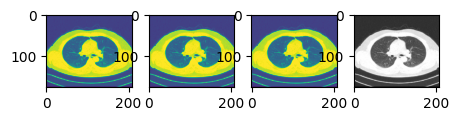

In [ ]:
# check image channels
plt.subplot(151)
plt.imshow(train_data[3,:,:,0])
plt.subplot(152)
plt.imshow(train_data[3,:,:,1])
plt.subplot(153)
plt.imshow(train_data[3,:,:,2])
plt.subplot(154)
plt.imshow(train_data[3,:,:,:])

# Create Model
or to load a model, skip down to "Load Model", then you can either continue training that model by skipping the next cell, or jump to "Evaluate Model"

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv2D, Add

class AttentionGate(Layer):
    def __init__(self, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)
        self.conv_g = Conv2D(filters=2048, kernel_size=(1, 1), padding='same')
        self.conv_x = Conv2D(filters=2048, kernel_size=(1, 1), padding='same')
        self.conv_f = Conv2D(filters=2048, kernel_size=(1, 1), padding='same')

    def call(self, inputs):
        x, g = inputs  # x is the input feature map, g is the gating signal
        g1 = self.conv_g(g)
        x1 = self.conv_x(x)
        psi = tf.nn.sigmoid(Add()([x1, g1]))
        return x * psi

# Example usage in a model
inputs = tf.keras.Input(shape=(None, None, 2048))  # Example input shape
gating_signal = tf.keras.Input(shape=(None, None, 2048))  # Example gating signal shape
attention_gate = AttentionGate()([inputs, gating_signal])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'attention_gate', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Add, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3

# Load InceptionV3 model without the top (fully connected) layers
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(dim[0], dim[1], 3), pooling=None)

# Freeze all layers in the InceptionV3 model
for layer in inception_model.layers:
    layer.trainable = False

# Apply attention gate mechanism
inception_output = inception_model.output

# Create an instance of the AttentionGate layer
attention_layer = AttentionGate()

# Pass the output of InceptionV3 through the attention gate
attention_output = attention_layer([inception_output, inception_output])

# Add residual connection
residual_output = Add()([inception_output, attention_output])

# Add Global Average Pooling to reduce spatial dimensions
pooled_output = GlobalAveragePooling2D()(residual_output)

# Add new trainable fully connected layers on top of the InceptionV3 model
fc1 = Dense(1024, activation='relu', kernel_initializer='he_uniform')(pooled_output)
dp1 = Dropout(0.25)(fc1)
output = Dense(3, activation='softmax')(dp1)  # Ensure this matches the number of classes

# Create the final model
model_with_attention = Model(inputs=inception_model.input, outputs=output)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'attention_gate_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [ ]:
# Compile the model
opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum, nesterov=True, name='SGD')
inception_model.compile(optimizer=opt, loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])


# Train the Model



In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
# Compile the model
model_with_attention.compile(optimizer='adam',  # You can choose any optimizer
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])

# Now, fit the model using the modified model with attention
batch_size = 32  # Reduce the batch size
model_history = model_with_attention.fit(train_data, train_labels, validation_data=(val_data, val_labels),
                                          epochs=eps, batch_size=batch_size, shuffle=True)


Epoch 1/45
24/24 ━━━━━━━━━━━━━━━━━━━━ 97s 4s/step - accuracy: 0.5838 - loss: 6.6262 - val_accuracy: 0.8727 - val_loss: 0.3511
Epoch 2/45
24/24 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.8277 - loss: 0.4615 - val_accuracy: 0.8818 - val_loss: 0.2971
Epoch 3/45
24/24 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.8441 - loss: 0.3593 - val_accuracy: 0.8818 - val_loss: 0.2353
Epoch 4/45
24/24 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.8958 - loss: 0.2173 - val_accuracy: 0.9182 - val_loss: 0.2203
Epoch 5/45
24/24 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - accuracy: 0.9146 - loss: 0.2142 - val_accuracy: 0.9000 - val_loss: 0.2236
Epoch 6/45
24/24 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.9425 - loss: 0.1451 - val_accuracy: 0.9182 - val_loss: 0.2133
Epoch 7/45
24/24 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.9353 - loss: 0.1512 - val_accuracy: 0.9091 - val_loss: 0.2008
Epoch 8/45
24/24 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.9570 - loss: 0.1092 - val_accuracy: 0.9091 - val_l

In [ ]:
scores = model_with_attention.evaluate(test_data, test_labels)
print("Accuracy: %.2f%%" %(scores[1]*100))

7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.9380 - loss: 0.1284
Accuracy: 93.18%


# Plots and Values

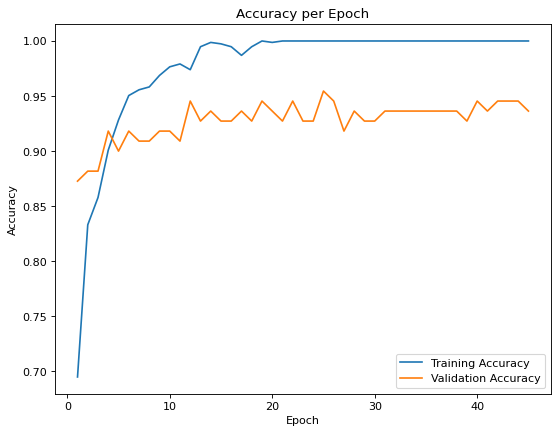

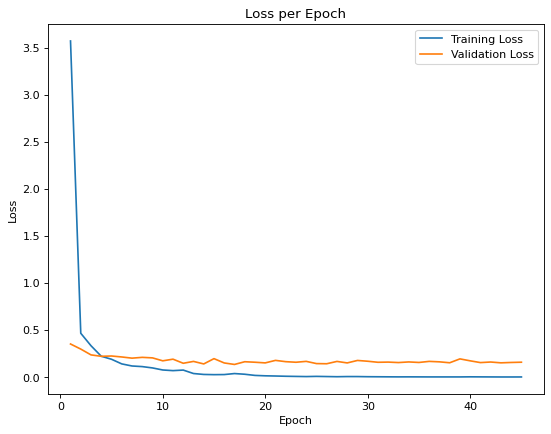

image dimensions:  (176, 208)
validation split percentage:  0.2
zoom:  [0.99, 1.01]
Learning Rate:  0.0001
batch size:  20
epochs:  45
brightness range:  [0.8, 1.2]
Model trained from scratch? :  True
Total Time Elapsed = 89 minutes


In [ ]:
# plot accuracy

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title('Accuracy per Epoch')
plt.plot(np.linspace(1,eps,num=eps),model_history.history['accuracy'], label = 'Training Accuracy')
plt.plot(np.linspace(1,eps,num=eps),model_history.history['val_accuracy'], label = 'Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()
#print(np.amax.model_history.history['val_accuracy'])

#Plot loss
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title('Loss per Epoch')
plt.plot(np.linspace(1,eps,num=eps),model_history.history['loss'], label = 'Training Loss')
plt.plot(np.linspace(1,eps,num=eps),model_history.history['val_loss'], label = 'Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# print out variable values
print('image dimensions: ',dim)
print('validation split percentage: ',validation_split_percent)
print('zoom: ',zoom)
print('Learning Rate: ',lr)
print('batch size: ',batch)
print('epochs: ',eps)
print('brightness range: ',bright_range)
print('Model trained from scratch? : ',layers_unlocked)
end = time.time()
print('Total Time Elapsed = %.2d minutes'%((end - start)/60))

# Performance Evaluation
Come here after loading model

In [ ]:
### PERFORMANCE EVALUATION ##
train_scores = model_with_attention.evaluate(train_data, train_labels)
val_scores = model_with_attention.evaluate(val_data,val_labels)
test_scores = model_with_attention.evaluate(test_data, test_labels)

print('Train Accuracy: %.2f%%'%(train_scores[1]*100))
print('Validation Accuracy: %.2f%%'%(val_scores[1]*100))
print('Test Accuracy: %.2f%%'%(test_scores[1]*100))

24/24 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 1.0000 - loss: 5.1786e-04
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9287 - loss: 0.1448
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.9380 - loss: 0.1284
Train Accuracy: 100.00%
Validation Accuracy: 93.64%
Test Accuracy: 93.18%


7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step
Shape of labels: (220,)
Shape of predic: (220,)


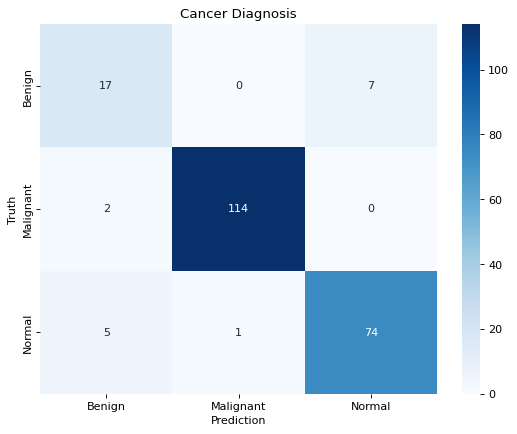

In [ ]:
## CONFUSION MATRIX ##
import numpy as np
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

predic = model_with_attention.predict(test_data)

# Modify this line to get the predicted class labels
# Assuming your model outputs probabilities, use argmax to get the class with the highest probability
predic = np.argmax(predic, axis=-1)  # Change axis to -1 to get the class from the last dimension

# If predic still has more than 2 dimensions, flatten it to 1D
predic = predic.flatten()

labels = np.argmax(test_labels, axis=1)

# Check the shapes of labels and predic to ensure they are compatible
print("Shape of labels:", labels.shape)
print("Shape of predic:", predic.shape)

conf_arr = confusion_matrix(labels, predic)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sn.heatmap(conf_arr, cmap='Blues', annot=True, fmt='d', xticklabels=['Benign', 'Malignant', 'Normal'],
                yticklabels=['Benign', 'Malignant', 'Normal'])
plt.title('Cancer Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [ ]:
## CONFUSION MATRIX ##

predict = model_with_attention.predict(train_data)

predict = np.argmax(predict, axis=1)
labelst = np.argmax(train_labels, axis=1)

conf_arrt = confusion_matrix(labelst, predict)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sn.heatmap(conf_arrt, cmap='Blues', annot=True, fmt='d', xticklabels= ['Benign', 'Malignant', 'Normal'],
                yticklabels=['Benign', 'Malignant', 'Normal'])
plt.title('Cancer Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
#plt.subplots(figsize=(9, 6))
plt.show(ax)


In [ ]:
# Install OpenCV
!pip install opencv-python



In [ ]:
# Clone the Darknet repository
!git clone https://github.com/pjreddie/darknet.git

Cloning into 'darknet'...
remote: Enumerating objects: 5955, done.
remote: Total 5955 (delta 0), reused 0 (delta 0), pack-reused 5955 (from 1)
Receiving objects: 100% (5955/5955), 6.37 MiB | 9.78 MiB/s, done.
Resolving deltas: 100% (3932/3932), done.


In [ ]:
# Download YOLOv3 weights
!wget https://pjreddie.com/media/files/yolov3.weights


--2024-11-12 04:17:41--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  44.8MB/s    in 5.3s    

2024-11-12 04:17:46 (44.9 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [ ]:
# Download YOLOv3 configuration file
!wget https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg


--2024-11-12 04:18:06--  https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘yolov3.cfg’

yolov3.cfg              [  <=>               ] 613.76K  2.31MB/s    in 0.3s    

2024-11-12 04:18:07 (2.31 MB/s) - ‘yolov3.cfg’ saved [628495]



In [ ]:

# Download COCO dataset class labels
!wget https://github.com/pjreddie/darknet/blob/master/data/coco.names -O /content/coco.names


--2024-11-12 04:20:14--  https://github.com/pjreddie/darknet/blob/master/data/coco.names
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘/content/coco.names’

/content/coco.names     [ <=>                ] 167.55K   968KB/s    in 0.2s    

2024-11-12 04:20:15 (968 KB/s) - ‘/content/coco.names’ saved [171576]



In [ ]:
import os

print("Weights file exists:", os.path.isfile("/content/yolov3.weights"))
print("Config file exists:", os.path.isfile("/content/yolov3.cfg"))


Weights file exists: True
Config file exists: True


In [ ]:
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg -O /content/yolov3.cfg

--2024-11-12 04:29:45--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘/content/yolov3.cfg’

/content/yolov3.cfg 100%[===================>]   8.15K  --.-KB/s    in 0s      

2024-11-12 04:29:45 (56.9 MB/s) - ‘/content/yolov3.cfg’ saved [8342/8342]



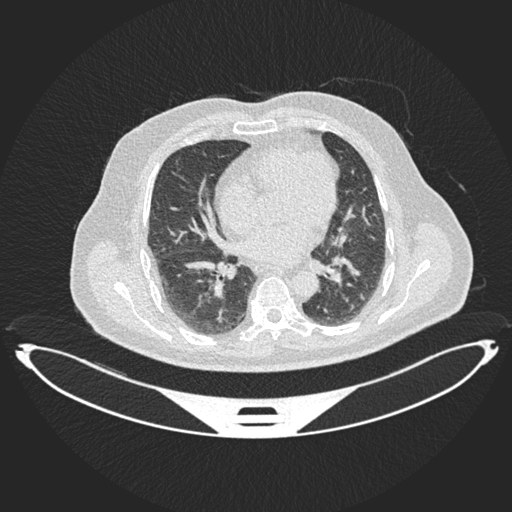

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Paths to model weights, config file, and class names
weights_path = "/content/yolov3.weights"
config_path = "/content/yolov3.cfg"
classes_path = "/content/coco.names"  # Ensure you have this file

# Load class names
with open(classes_path, "r") as f:
    classes = [line.strip() for line in f.readlines()]

# Load YOLO model
net = cv2.dnn.readNetFromDarknet(config_path, weights_path)
layer_names = net.getLayerNames()

# Get output layer indices (OpenCV 4.x)
output_layers_indices = net.getUnconnectedOutLayers()
# Reshape to a 1D array if it's 2D
output_layers_indices = output_layers_indices.reshape(-1)

# Get output layer names using the indices
output_layers = [layer_names[i - 1] for i in output_layers_indices]


# Load image
image_path = "/content/drive/MyDrive/test/Benign/Bengin case (1).jpg"  # Replace with your image path
image = cv2.imread(image_path)
height, width, channels = image.shape

# Prepare the image for the model
blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
net.setInput(blob)
outs = net.forward(output_layers)

# Process the outputs
boxes = []
confidences = []
class_ids = []

for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:  # Confidence threshold
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)

            # Rectangle coordinates
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)

            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

# Apply Non-Max Suppression
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

# Draw bounding boxes
for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(image, label, (x, y + 30), cv2.FONT_HERSHEY_PLAIN, 3, (0, 255, 0), 3)


# Show the image using cv2_imshow
cv2_imshow(image) # Use cv2_imshow instead of cv2.imshow
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
!pip install tensorflow keras opencv-python

In [ ]:
!pip install kaggle


In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json here


Saving kaggle .json to kaggle .json


{'kaggle .json': b'{"username":"saivenkat2002","key":"f2fb1dbc6df108380da4f5f38bb9b5c8"}'}

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Set permissions

# Use the Kaggle API to download a model (for example, from a dataset or competition)
!kaggle datasets download -d <dataset-or-model-id>


mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
/bin/bash: -c: line 1: syntax error near unexpected token `newline'
/bin/bash: -c: line 1: `kaggle datasets download -d <dataset-or-model-id>'


In [ ]:
from google.colab import files
files.download('unet_model.h5')  # This will prompt you to download the model


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
uploaded = files.upload()  # This will prompt you to upload files

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


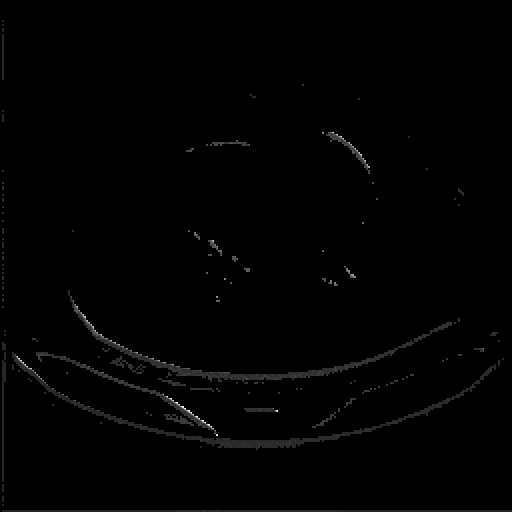

In [ ]:
import cv2
import numpy as np
from keras.models import load_model
# Import the necessary function for image display in Colab
from google.colab.patches import cv2_imshow

# Load the pre-trained U-Net model
model = load_model('unet_model.h5')

# Load and preprocess the image
image = cv2.imread('/content/drive/MyDrive/test/Benign/Bengin case (1).jpg')
image_resized = cv2.resize(image, (256, 256))  # Resize to model input size
image_normalized = image_resized / 255.0  # Normalize
image_input = np.expand_dims(image_normalized, axis=0)  # Add batch dimension

# Predict the mask
predicted_mask = model.predict(image_input)
predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Binarize the mask

# Resize the mask back to original image size
predicted_mask_resized = cv2.resize(predicted_mask[0], (image.shape[1], image.shape[0]))

# Apply the mask to the original image
localized_image = cv2.bitwise_and(image, image, mask=predicted_mask_resized)

# Show the localized image using cv2_imshow() instead of cv2.imshow()
cv2_imshow(localized_image) # Use cv2_imshow for displaying in Colab
#cv2.waitKey(0)  # These are not needed with cv2_imshow
#cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


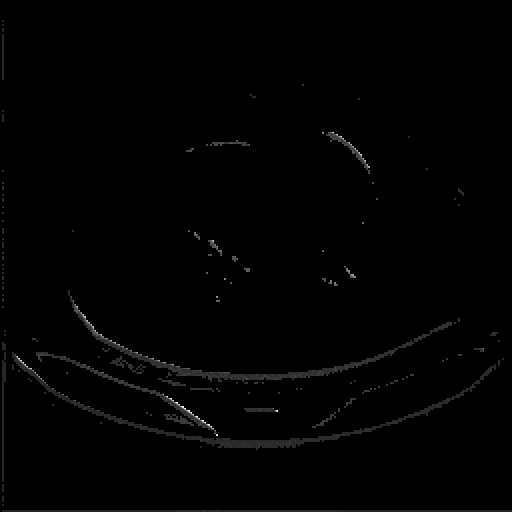

In [ ]:
import cv2
import numpy as np
from keras.models import load_model
# Import the necessary function for image display in Colab
from google.colab.patches import cv2_imshow

# Load the pre-trained U-Net model
model = load_model('unet_model.h5')

# Load and preprocess the image
image = cv2.imread('/content/drive/MyDrive/test/Benign/Bengin case (1).jpg')
image_resized = cv2.resize(image, (256, 256))  # Resize to model input size
image_normalized = image_resized / 255.0  # Normalize
image_input = np.expand_dims(image_normalized, axis=0)  # Add batch dimension

# Predict the mask
predicted_mask = model.predict(image_input)
predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Binarize the mask

# Resize the mask back to original image size
predicted_mask_resized = cv2.resize(predicted_mask[0], (image.shape[1], image.shape[0]))

# Apply the mask to the original image
localized_image = cv2.bitwise_and(image, image, mask=predicted_mask_resized)

# Show the localized image using cv2_imshow() instead of cv2.imshow()
cv2_imshow(localized_image) # Use cv2_imshow for displaying in Colab
cv2.waitKey(0)  # These are not needed with cv2_imshow
cv2.destroyAllWindows()

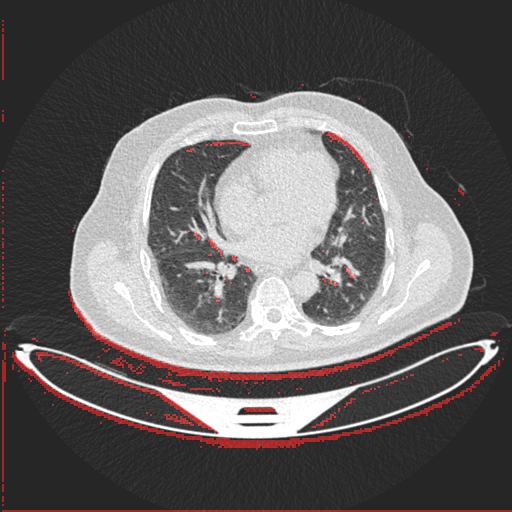

In [ ]:
# Apply the mask to the red overlay
highlighted_area = cv2.bitwise_and(red_overlay, red_overlay, mask=predicted_mask_resized)

# Combine the original image with the red highlighted area
localized_image = cv2.addWeighted(image, 1, highlighted_area, 0.5, 0)  # Adjust 0.5 for transparency

# Show the localized image using cv2_imshow
cv2_imshow(localized_image)
